# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Group 15: William Jones, Elliot Leishman, Tristan Pang and Aidan Garrity

## General Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# sklearn modules that are necessary
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

In [2]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
cmap = plt.get_cmap("tab10") # define colours
sns.set(rc={'figure.figsize': (14, 8)})

In [3]:
# Load data
data = pd.read_csv("the_office.csv")

## 1. Introduction


Intro
IMDb ratings give a valuable indicator on how popular episodes of television shows are with viewers. NBC Universal would like to understand what makes certain episodes of The Office more popular than others, so they can produce a special reunion episode with as high an IMDb rating as possible. 

This report uses data on The Office to build and validate a predictive model that captures the underlying relationship between episode features and IMDb rating, and advises on what NBC Universal should include in a reunion episode to maximise audience popularity. 

We achieve this by first performing data exploration to select or remove certain features, we then investigate the effectiveness of different regression models using a training-test split of our data. 

The first model we investigate is a basic linear regression model, this model has an R^2 number of […]. This model provides a baseline from which we will look to improve on later in the report.

The main models we examine use ridge regression and LASSO (least
absolute shrinkage and selection operator). These models have an advantage over linear regression because they contain an additional loss function (L1 for LASSO and L2 for Ridge). These loss functions force the regression coefficients to tend to zero, which in turn lowers the variance. The LASSO model has an test R^2 of aorund a quarter.

Finally, we settle on an ElasticNet model which combines both the L1 and L2 loss functions. We implement this model with 2nd order polynomial interaction terms and cross validation to minimise overfitting. This model gives a test R^2 of 0.45. This is the model we will use to make our predictions.

The primary dataset we are using is displayed below. We have a dataset of every episode of the office, critically containing an IMDb rating for each episode amongst other features which are either categorical (writers, characters etc.) or numeric (number of lines, number of directions etc.). We use one-hot encoding to encode the categorical variables. 

We also introduce some additional data [1], from which we develop some useful features. The dataset is the script of the entire show - each row of the dataset contains an episode, series and scene number, a line said in the show ('line_text'), the character ('speaker') who said the line, and whether the line was in a deleted scene or not. From this we can find the number of scenes ('n_scenes') said in each episode, which gives an idea of optimal episode pacing, and the number of lines each main character says in each episode, effectively ranking a character's importance in an episode. 


In [4]:
# load additional data [1]
data_lines = pd.read_csv("the-office-lines.csv")

# display both datasets
display(data)
display(data_lines)

### Initial data manipulation ###

# remove deleted scenes
data_lines = data_lines[~data_lines.deleted]

# get number of scenes per episode
n_scenes = data_lines.groupby(['season', 'episode'])['scene'].max()

# add number of scenes per episode to our dataframe
data['n_scenes'] = np.array(n_scenes)

# add count column to dataframe
data_lines['n_lines'] = 1

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,9,19,Stairmageddon,Matt Sohn,Dan Sterling,8.0,1484,2013-04-11,273,59,2965,24,Andy;Angela;Creed;Dwight;Erin;Jim;Kevin;Meredi...
182,9,20,Paper Airplane,Jesse Peretz,Halsted Sullivan;Warren Lieberstein,8.0,1482,2013-04-25,234,48,2564,27,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
183,9,21,Livin' the Dream,Jeffrey Blitz,Nicki Schwartz-Wright,8.9,2041,2013-05-02,382,33,4333,20,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
184,9,22,A.A.R.M,David Rogers,Brent Forrester,9.3,2860,2013-05-09,501,54,4965,30,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...


,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False
...,...,...,...,...,...,...,...
59904,59905,9,23,112,It all seems so very arbitrary. I applied for ...,Creed,False
59905,59906,9,23,113,I just feel lucky that I got a chance to share...,Meredith,False
59906,59907,9,23,114,I���m happy that this was all filmed so I can ...,Phyllis,False
59907,59908,9,23,115,I sold paper at this company for 12 years. My ...,Jim,False


## 2. Exploratory Data Analysis and Feature Engineering

### 2.1 A brief overview of the data

In [5]:
# Investigate the datatypes of the dataset
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
 13  n_scenes      186 non-null    int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 20.5+ KB


None

Our dataset contains 186 rows (observations) with 13 columns (features). We have already identified 'imdb_rating' as our output, leaving us with 12 features. 

The non-null count column tells us we have no null values in our dataset, therefore no cleaning regarding these values is needed. However, only having 186 data points may make finding a good $R^2$ score hard, as the model will be heavily dependent on the train-test split. Ideally we would have more datapoints than this but there are only 186 episodes available. 

Seven of our columns are of datatype 'int64' - by checking the columns we see that storing these values as integers seems sensible and no manipultion of the features is necessary. There is one feature of datatype 'float64', namely 'imdb_rating', this is an appropriate datatype because IMDb report ratings with an accuracy of 1 decimal place. It is important to note that 'imdb_rating' is capped at 10.0, but this may be hard to implement.

Finally, we have five features of datatype 'object', these features will be given special consideration in this section.

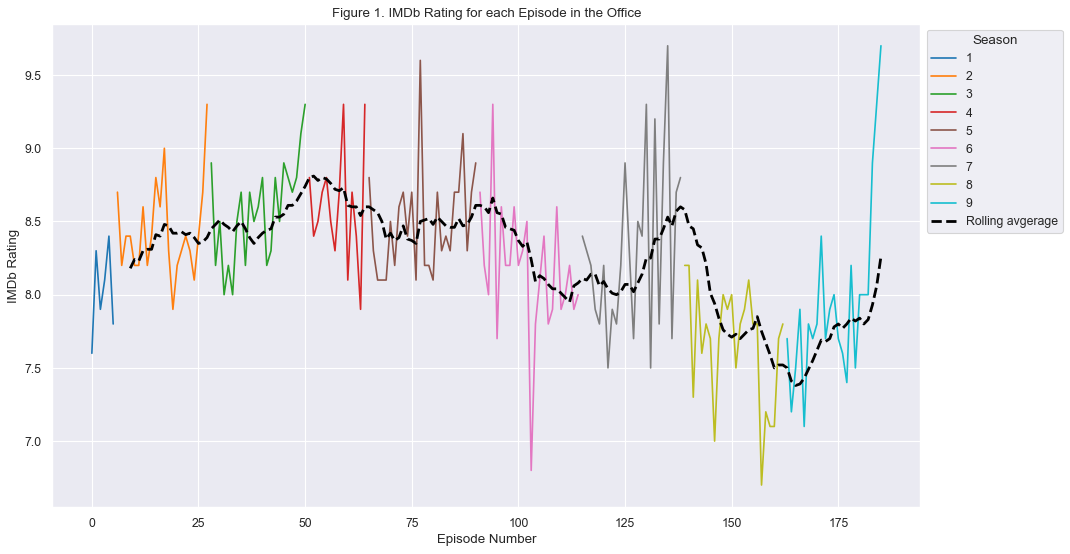

In [6]:
# Create a new DataFrame from data which includes an index column, corresponding to episode number.
data_indexed = data.reset_index() 

# Plot ratings of each season
ax = sns.lineplot(data = data_indexed, x = 'index', y = 'imdb_rating', hue = 'season', palette= cmap, legend = 'full')

# Calculate and plot rolling average onto existing figure
data_indexed[ '10ep_rolling_avg' ] = data_indexed.imdb_rating.rolling(10).mean()
sns.lineplot( x = 'index', y = '10ep_rolling_avg', data = data_indexed, label = 'Rolling avgerage', linestyle='dashed', color = 'black', linewidth = 2.5)

# Axis setup
ax.legend(title = 'Season')

# Legend
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Plot Formatting
plt.title('Figure 1. IMDb Rating for each Episode in the Office')
plt.xlabel('Episode Number')
plt.ylabel('IMDb Rating')
plt.show()



Although this figure does not provide an in-depth look at each episode, it does give us the general trend in IMDb rating as the show progressed as well as hightlighting potential outliers in the dataset. 

By looking at the rolling average we can see the show experienced a slow and steady increase in ratings throughout the first three seasons. This is most likely due to the show finding its feet and developing its own identity. The shows ratings appear relatively stable throughout the next 4 seasons except a small dip towards the end of season 6 and continuing into the beginning of season 7. It is season 8 where the show experienced its biggest decline in ratings, this could be due to many factors, such as the show losing creativity in writing/ directing or a shake-up in the cast members. Interestingly, the shows ratings increased into the final season, and continued on an upward trajectory thorughout the season, perhaps due to nostalgia. Other trends we can see from the figure is importance of the season finale. Note that in seasons 2,3,4 and 9, the season finale appears to be the highest rated episode in the season. This could be due to the payoff of several theme and character arcs from the season.

An interesting outlier is the lowest rated episode in season 6. Although this is not the overall lowest rated episode, it is clearly the episode which deviates (negatively) from it's season average the most. Another outlier is the final episode of the entire series, which is the (joint) highest rated episode of the series. This is likely due to it being the finale, rounding off the show. 

### 2.2 Data Cleaning

We choose not to remove the above outlier episodes as they may give some indication into what features gives a particularly good or bad episode - for example, the fan favorite character 'Michael' returns in the final episode of the series after being absent in seasons 8 and 9, which may have been a contributing factor the spike in rating. 

At this point it is important to remember the brief of our task 'to advise what NBC Universal should do to produce the highest rated reunion episode possible'. Many features in the data set are not controllable when making a new episode. We will not include the following features:
- 'season' and 'episode'. A special reunion episode will not fit into the standard seasons format, and the network could not control which season a new episode would fit into.
- 'air_date'. The reunion episode will air significantly after the official finale in 2013. 
- 'episode_name'. These are unique strings and will be dictated by episode content. 
- 'total_votes'. This may be a good indicator of how well an episode is doing, but it is not a factor we can control. 

In [7]:
# Drop irrelevant columns
data = data.drop(columns=['season', 'episode', 'episode_name', 'air_date', 'total_votes'])

### 2.3 Feature Investigation: Numerical

In this section we will examine the numeric features in the dataset, as well as their relationship with each other and 'imdb_rating'.

#### 2.3.1 Correlation

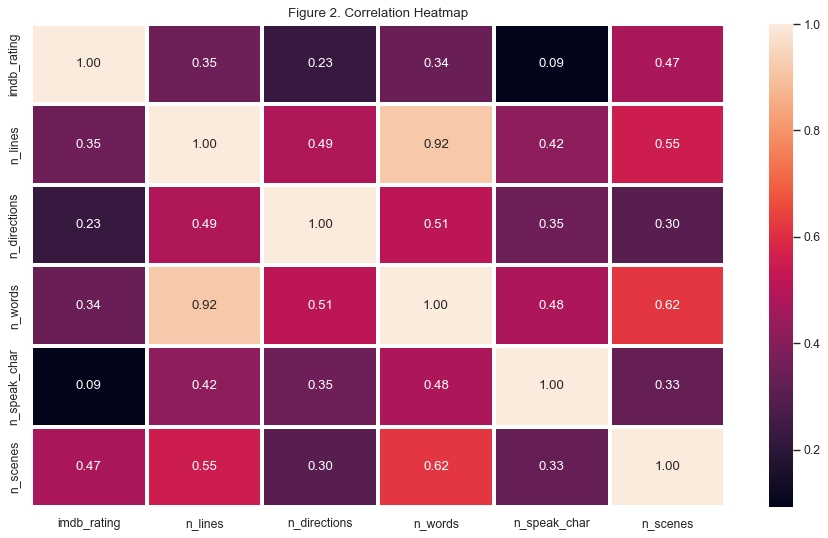

In [8]:
# Correlation heatmap 
sns.heatmap(data.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 2. Correlation Heatmap")
plt.show()

From Figure 2 we can see that every feature is positively correlated with every other feature. The strongest correlation is between 'n_words' and 'n_lines' which suggests that the number of words per line is consistent throughout the series and we only really need one of these features in our model. Rather than removing one outright we will keep this in mind when selecting a model. Furthermore, the features most highly correlated with 'imbd_rating' are 'n_lines' and 'n_words'. The correlation between features is something we will keep in mind when developing our model.

#### 2.3.2 Diagnostic Plots

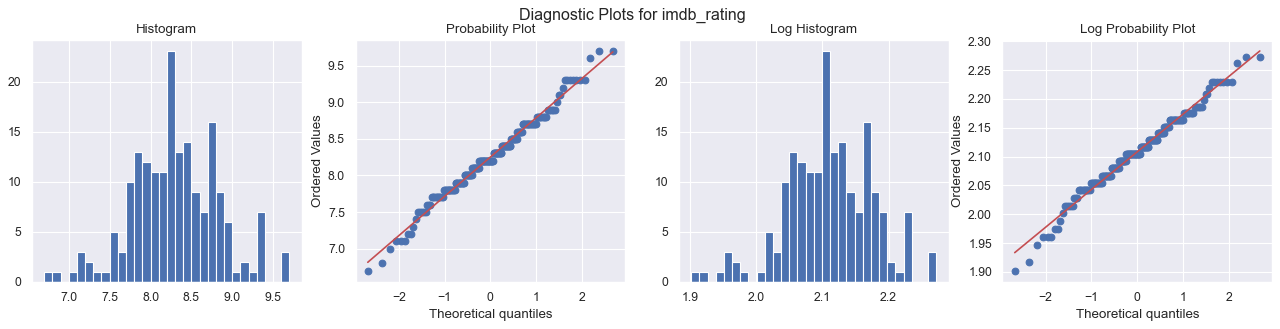

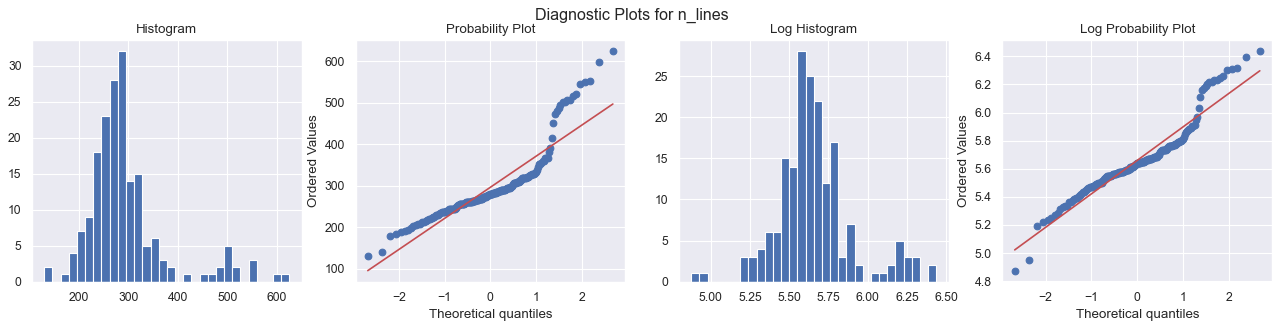

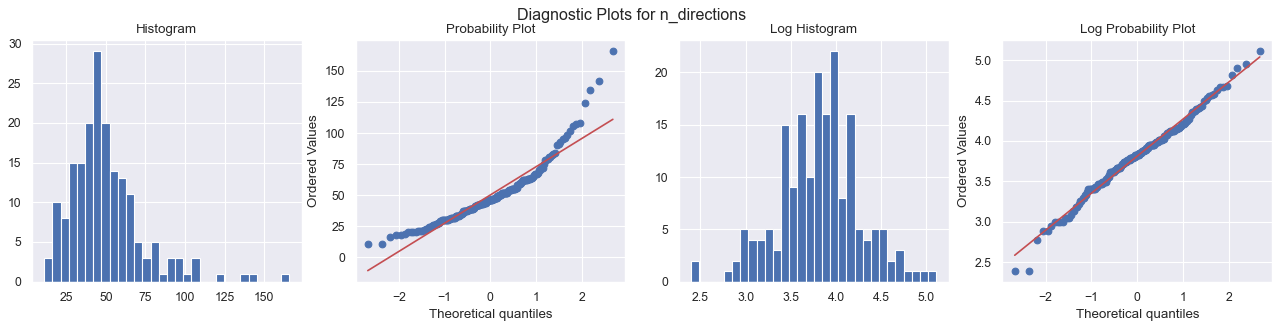

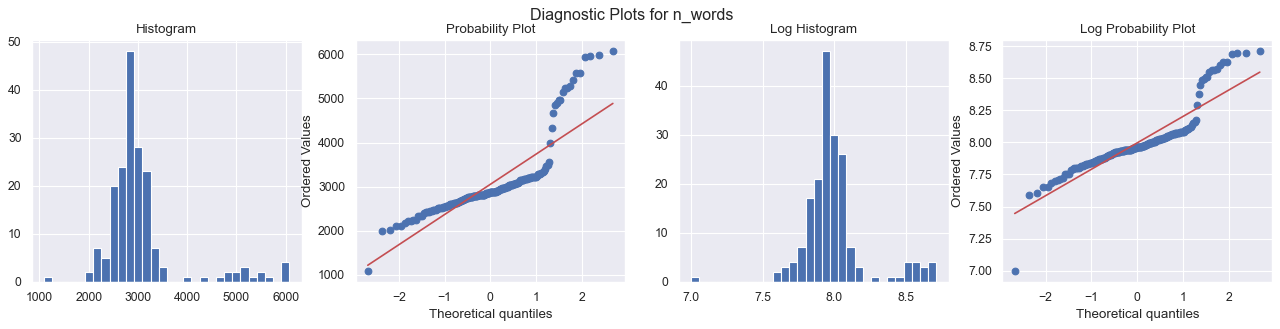

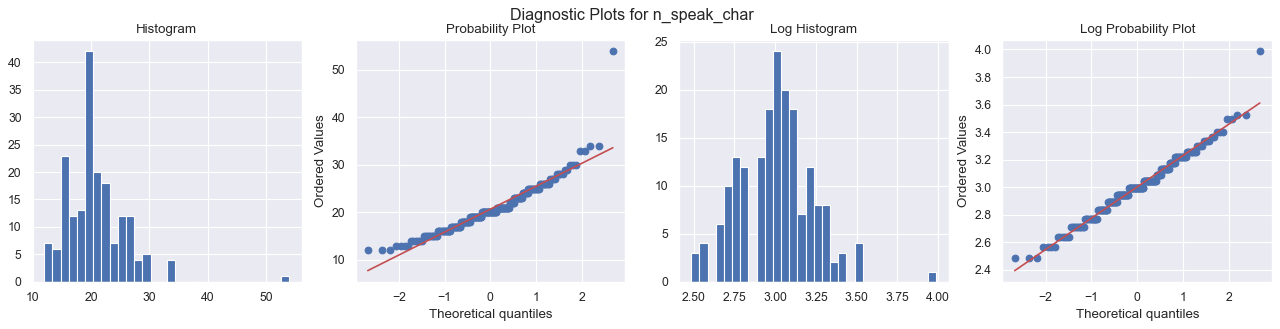

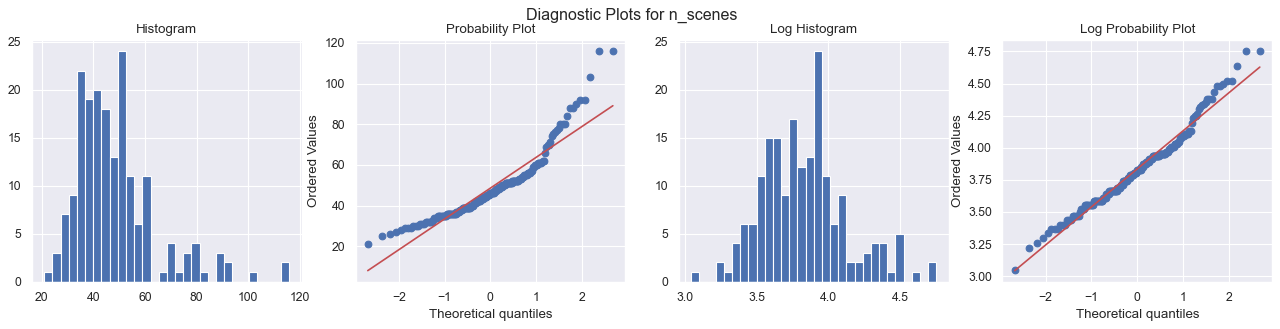

In [9]:
def diagnostic_plots(df, variable): 
    """
        Distributions of variable in dataframe - from Python Feature Engineering Cookbook.
        Outputs histogram, probability plot, log histogram, and log probability plot of variable distribution. 
    """

    plt.figure(figsize=(20,4)) 

    # Histogram
    plt.subplot(1, 4, 1) 
    df[variable].hist(bins=30)
    plt.title("Histogram")

    # Probability Plot
    plt.subplot(1, 4, 2)
    stats.probplot(df[variable], dist="norm", plot=plt) 

    # Log Histogram
    plt.subplot(1, 4, 3) 
    np.log(data[variable_name]).hist(bins=30)
    plt.title("Log Histogram")

    # Log Probability Plot
    plt.subplot(1, 4, 4)
    stats.probplot(np.log(data[variable_name]), dist="norm", plot=plt) 
    plt.title("Log Probability Plot")

    plt.suptitle("Diagnostic Plots for {}".format(variable))
    plt.show()

# run the diagnostic plots for all the features we are interested in 
for variable_name in data.select_dtypes(exclude = 'object'): # excludes columns with data type object, i.e. only investigate numeric values
    diagnostic_plots(data, variable_name)

The histogram and QQ-plot for 'imdb_rating' suggest that the ratings are normally distributed. For 'n_lines' we see that the distribution is heavily skewed to the left - we tackle this by considering the logarthim of the variable, which appears to shift the distribution. Note, the histogram and QQ-plot of 'log(n_lines)' look like a normal distribution. Similarly, 'n_directions', 'n_words' and 'n_speak_char' are all closer to normally distributed when logged. Therefore, we would expect to use logged values in our analysis...

In [10]:
# log the appropriate data
data['n_scenes'] = np.log(data['n_scenes'])
data['n_directions'] = np.log(data['n_directions'])

### 2.4 Feature Investigation: Categorical
In this subsection we will investigate the three remaining categorical variables: Characters, Writers, and Directors. 

#### 2.4.1 Data Formatting
From the tableau of data in section 1 we see that the raw categorical data is not in a useful form - for example a writer may be 'Ricky Gervais;Stephen Merchant;Greg Daniels', three writers stored as one long string seperated by ';'. We would like to format this to be a list of names (strings) with no spaces and the hyphen removed from any double-barrelled surnames. We also don't care about any individuals who haven't worked on or appeared in many episodes. We make use of the following 'split_names' function.

In [11]:
def split_names(column, minimum = -np.inf, df=data):
    '''
        Split names in a specified column by `;` and ignore other puntuation. Drop individuals with less than or equal to a 'minimum' number of episodes.

        PARAMETERS: 
            - column (String): Name of column to split names over
            - minimum (Int): Minimum number of episodes an individual should appear in
            - df (Pandas DataFrame): Dataset

        RETURNS:
            - data_column (Pandas Series): Formatted column containing names or lists of names 
    '''

    # Retrieve data 
    data_column = (df[column]).copy()
    
    # Remove punctuation
    for punc in [' ', '.', '-']:
        data_column = data_column.str.replace(punc,'')
    
    # Split semicolon
    data_column = data_column.str.split(';',expand=False)
    
    # all possible people
    allpeople = [item for sublist in data_column.to_list() for item in sublist].copy() 

    # number of episodes corresponding to a person 
    peopleepisodes = {x: allpeople.count(x) for x in allpeople}.copy() 
    
    # new data without people <= minimum
    new_data_column = [] 

    # iterate over all data
    for episode in data_column: 

        new_episode = []

        # iterate over episodes
        for contributor in episode: 

            # if person has enough episodes, add to new data
            if peopleepisodes[contributor] > minimum: 
                new_episode.append(contributor)

        # if no one has over minimum, then set label as other
        if new_episode == []: 
            new_episode.append('Other') 

        new_data_column.append(new_episode)
        
    new_data_column = pd.Series(new_data_column)
    data_column = pd.get_dummies(new_data_column.apply(pd.Series).stack()).sum(level=0)

    return data_column.copy()

In [12]:
def boxplot(df1, output, xlabel = None, title = None):
    '''
        Generate a boxplot of individuals against IMDb rating.
    '''

    # create dataframe to get a boxplot from
    df2 = pd.merge(output, df1, left_index=True, right_index=True)

    plotting=[]

    # plot every individual seperately in the boxplot 
    for character in df1:
        condition = character + '==1'
        plotting.append(df2.query(condition)['imdb_rating'])

    # plot and label boxplot
    plt.boxplot(plotting)
    plt.xticks(rotation = 315)
    plt.xticks(np.arange(1,len(df1.columns) + 1), df1.columns)
    plt.xlabel(xlabel)
    plt.ylabel('IMDb Rating')
    plt.title(title)
    plt.show()


#### 2.4.2 Characters

In this section, we explore how individual characters affect the shows rating, making use of the split_names function.

,imdb_rating,Andy,Angela,Creed,Darryl,Dwight,Erin,Jim,Kelly,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
157,6.7,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
103,6.8,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1
146,7.0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0
160,7.1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,0
167,7.1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,9.3,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,0
59,9.3,1,1,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0
77,9.6,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0
135,9.7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


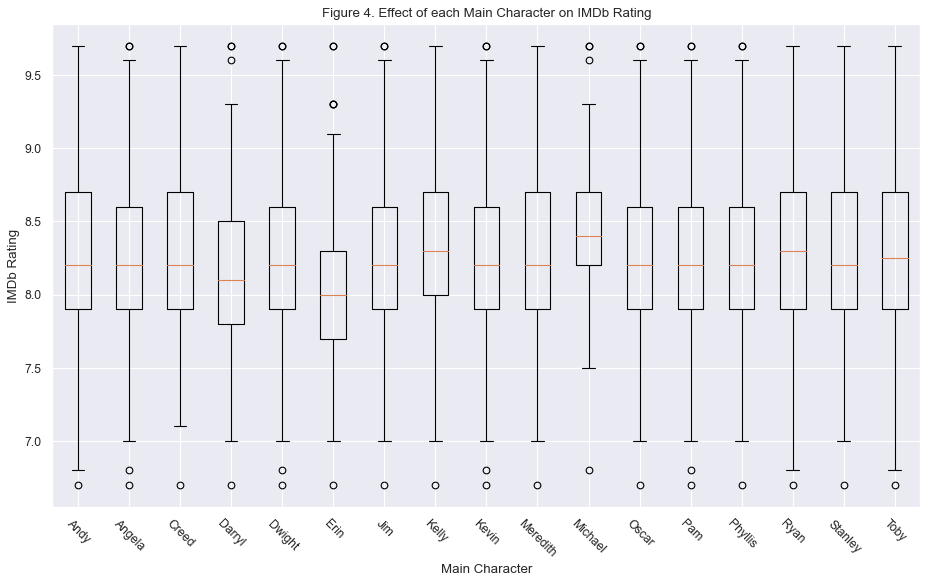

In [13]:
# Use split_names to create a feature for each main character
chars = split_names('main_chars')

# Merge IMDb rating into character DataFrame
chars2 = pd.merge(data['imdb_rating'], chars, left_index=True, right_index=True)

# sort character DataFrame by IMDb rating, to visualise characters in the bottom and top 5 episode
display(chars2.sort_values(by = ['imdb_rating']))

# Create a boxplot visualisng the effect on rating by each character
boxplot(chars, data['imdb_rating'], xlabel = 'Main Character', title = 'Figure 4. Effect of each Main Character on IMDb Rating')

Figure 4 shows that the character with the highest median episode rating is Michael and the character with the lowest is Erin. The boxplots show generally uniform ratings for each character. One reason for this is the ensemble cast nature of the show; most characters appear in most episodes. Other interesting observations about Michael is that he is not only the character with the smallest inter-quartile range, but he also has smallest whiskers on his boxplot. These observations imply that Michael is consistently in high-rated episodes and we expect our model to incorporate him. This is backed up by observing that Michael appears in four of the top five rated episodes, whilst only occurring in 1 of the 5 least highly rated episodes.

We would like to consider how many lines each character says in each episode, effectively ranking their importance in each episode. We can gather this information from the 'data_lines' DataFrame introduced in section 1. Due to the structure of this DataFrame, we must reindex it to the episode's overall episode in the entire series, and we don't want to consider any deleted scenes. We can then use this information to effectively correlate the characters against each other.

speaker,Andy,Angela,Creed,Darryl,Dwight,Erin,Jim,Kelly,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
overall_episode,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,0.0,29.0,0.0,36.0,0.0,1.0,0.0,81.0,3.0,41.0,2.0,8.0,5.0,0.0
1,0.0,4.0,0.0,0.0,19.0,0.0,27.0,2.0,8.0,0.0,81.0,13.0,16.0,0.0,4.0,5.0,2.0
2,0.0,5.0,0.0,0.0,62.0,0.0,42.0,0.0,6.0,3.0,56.0,9.0,32.0,0.0,1.0,6.0,0.0
3,0.0,7.0,0.0,0.0,58.0,0.0,49.0,0.0,3.0,10.0,79.0,14.0,22.0,5.0,4.0,2.0,4.0
4,0.0,3.0,0.0,15.0,26.0,0.0,22.0,0.0,1.0,0.0,106.0,2.0,14.0,4.0,8.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,31.0,4.0,2.0,0.0,61.0,10.0,15.0,0.0,5.0,2.0,0.0,7.0,9.0,5.0,0.0,21.0,15.0
182,39.0,16.0,1.0,10.0,21.0,16.0,17.0,0.0,10.0,0.0,0.0,2.0,22.0,0.0,0.0,2.0,7.0
183,68.0,30.0,2.0,11.0,54.0,9.0,63.0,0.0,13.0,1.0,0.0,19.0,30.0,4.0,0.0,4.0,7.0


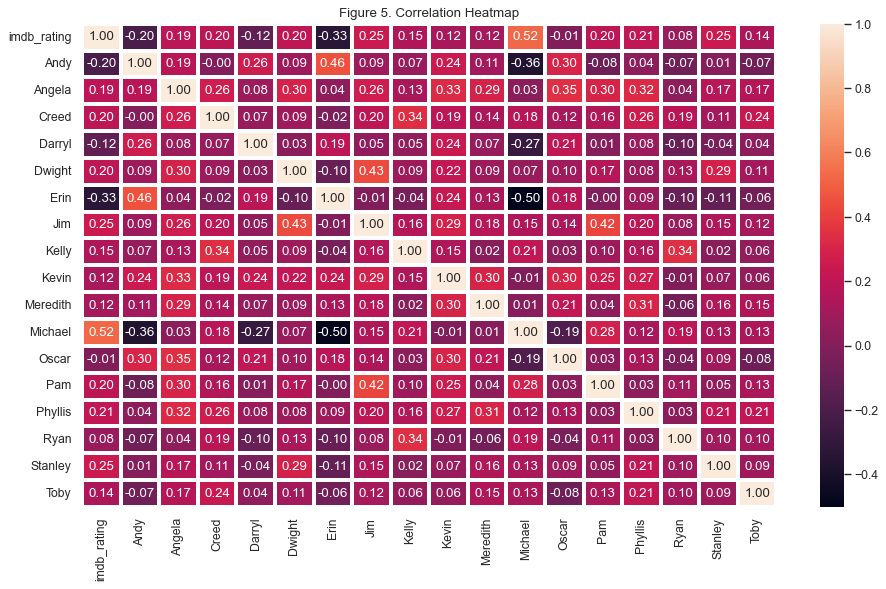

In [14]:

# set index of lines data to be the season and episode number 
reindex_df = pd.DataFrame(data_lines.groupby(['season', 'episode']).sum()).reset_index()

## label each row with it's overall episode in the entire series 
data_lines['overall_episode']=0 # introduce overall episode column

# loop over each episode
for overall_episode in reindex_df.index:
    s, e = reindex_df[['season','episode']].loc()[overall_episode] # get the season and season's episode number 
    index = [(data_lines['season']==s) & (data_lines['episode']==e)] # consider only that season and episode 
    data_lines['overall_episode']=data_lines['overall_episode']+(np.array(index)*overall_episode)[0] # label the season and episode lines with the overall episode

## Get the number of lines each character says in each episode 
n_lines_character = data_lines.groupby(['overall_episode', 'speaker'])['n_lines'].sum() # sum how many lines appear in each episode 
n_lines_character = n_lines_character.reset_index() # reset the index for all characters
n_lines_character = n_lines_character[n_lines_character['speaker'].isin(chars.columns)] # only include main characters 
n_lines_character = n_lines_character.reset_index() # reset the index after removing characters
n_lines_character = n_lines_character.pivot(index='overall_episode',columns='speaker',values='n_lines').fillna(0) # reformat table

# display tableau
display(n_lines_character)

# generate correlation plot for characters against each other
sns.heatmap(pd.merge(data['imdb_rating'], n_lines_character, left_index=True, right_index=True).corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 5. Correlation Heatmap")
plt.show()

The correlation heatmap in Figure 5 shows that Michael is the charcter with greatest correlation with IMDb rating, which again reaffirms the importance of Michael to the fans and hence the ratings. Another thing of note in the figure is lack of any data Dwight, this is because Dwight appears in every single episode and hence there is zero variance in his appearance. This is importand because the formula to calculate correlation coefficient involves a division by variance. Thus dividing by zero gives us an error. Finally we note that most the characters aren't too strongly correlated with each other, with the obvious exceptions of Ryan and Kelly, positively, as well as Erin and Michael and Darryl and Michael, negatively. Therefore, we do not expect too many issues due to correlated features here.

#### 2.4.3 Writers

We explore the writers in a little less depth. In the writers feature there are writers who only wrote a very small number of episodes. These writers may have an adverse effect on our model so we have decided to disregard any individual who wrote less than three episodes. Episodes written by a writer with fewer than 3 episodes will be recorded as being written by 'other'.

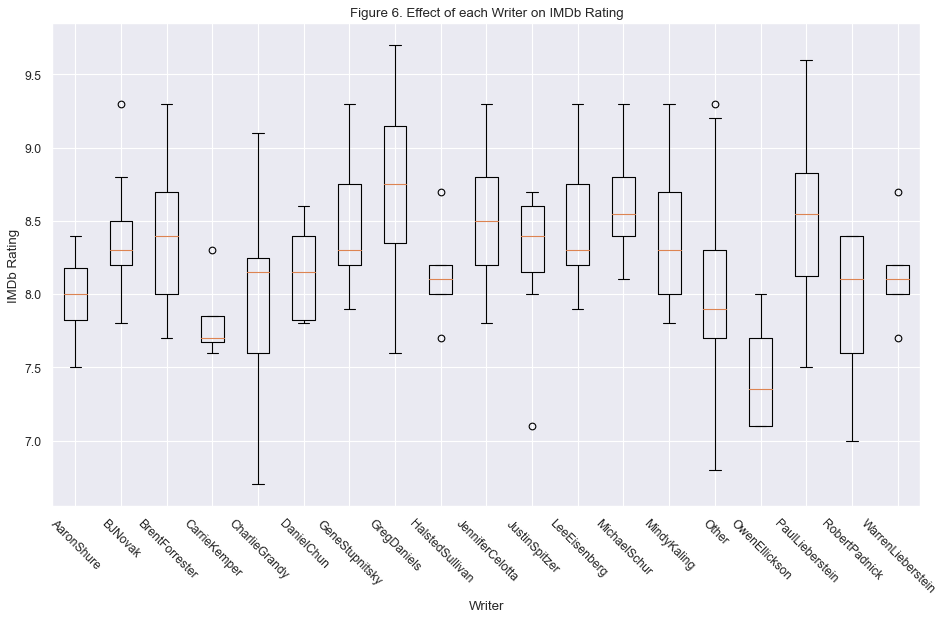

In [15]:
# Create a DataFrame of writers information.
writers = split_names('writer', minimum=3)

# Add Imdb rating to this DataFrame.
writers2 = pd.merge(data['imdb_rating'], writers, left_index=True, right_index=True)

# Create a boxplot visualisng the effect on rating by each write
boxplot(writers, data['imdb_rating'], xlabel = 'Writer', title = 'Figure 6. Effect of each Writer on IMDb Rating')

We can see much more variation in ratings by writers rather than characters. This is likely because writers have much more creative freedom for each episode and only write a few episodes each, versus characters appearing all the time. It is clear Greg Daniels is the best writer, with the highest mean episode rating, and best overall episode, so we would expect our model to incorporate him. 

#### 2.4.4 Directors

We treat directors in a similar way to writers, and see similar results, but there are no stand out directors.

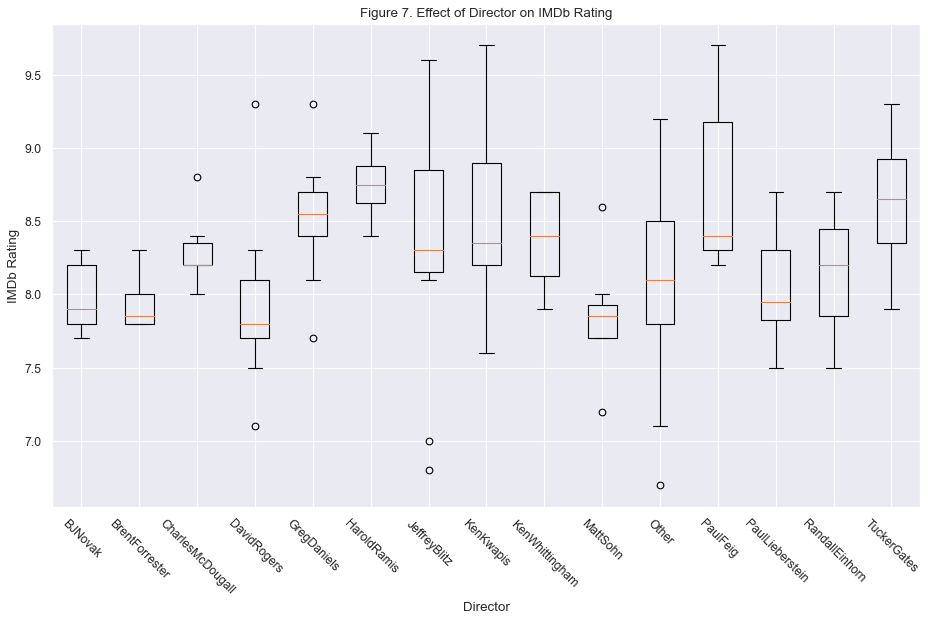

In [16]:
# Create a DataFrame of writers information.
direc = split_names('director', minimum=3)

# Add Imdb rating to this DataFrame.
direc2 = pd.merge(data['imdb_rating'], writers, left_index=True, right_index=True)

# Create a boxplot visualisng the effect on rating by each write
boxplot(direc, data['imdb_rating'], xlabel = 'Director', title = 'Figure 7. Effect of Director on IMDb Rating')

## 3. Model Fitting and Tuning

Now that we have a good idea about the structure of the data, we will split the data into train and test datasets, then try and fit it to different models. We will start with a simple linear model, which will allow us to gain more insight into the significance of our features, and give us a baseline to compare other models to. Since we have a lot of features, it would not be a suprise to run into overfitting issues when our model predicts the training data much better than the test data.

To remedy overfitting, we shall carefully select features (and possible higher order terms and interaction terms) using LASSO, which drops insignificant features of the train dataset. Once we fine-tune our features, then we can perform more complex and expensive regression in the hopes of finding a good model.

We shall first import the helper function `model_fit` from Workshop 5 and setup our dataset. Thess will allow us to evaluate our model.

## Setup ⚙

In [17]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [18]:
from sklearn.metrics import r2_score
def print_r2(model, do_print=True):
    '''Takes a model and predicts the data using the test/train data and prints Rsquared value'''
    # Use the model to predict train and test data
    global y_train_pred, y_test_pred
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Rsquared
    test_r2 = r2_score(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Print Rsquared
    if do_print == True:
        print(r'Train R^2', train_r2)
        print(r'Test R^2', test_r2)
    else:
        return train_r2,test_r2

In [19]:
# Organise our features
people = n_lines_character.join(writers) # get list of writers
people = people.join(direc.add_suffix('_D')) # get list of directors

head = [ 'n_lines', 'n_directions', 'n_words', 'n_speak_char'] # Basic features
X_ = pd.merge(data[head], people, left_index=True, right_index=True) # All features
head = list(X_.keys()) # List of headers
X_ = X_.fillna(0) # NaN shenanigans

y = data['imdb_rating'] # Response variable

# Split dataset into 20% test and 80% train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.20, random_state=71) # Set seed for replicability 

## Linear Regression 📉

In [20]:
from sklearn.linear_model import LinearRegression

# Regress the regression 
test_linear_model = LinearRegression()
test_linear_model.fit(X_train,y_train)

# Rsquared
print_r2(test_linear_model)

# Coefficients of linear fit
coeffs = pd.DataFrame(test_linear_model.coef_, head, columns=['Coefficients'])
coeffs.sort_values(by='Coefficients',ascending=False).head(10)

Train R^2 0.46793856334403927
Test R^2 0.5259355004147633


,Coefficients
TuckerGates_D,0.510415
BrentForrester,0.316597
GregDaniels,0.299688
BJNovak,0.291077
CharlesMcDougall_D,0.290339
MindyKaling,0.243499
GregDaniels_D,0.215925
MichaelSchur,0.189950
PaulLieberstein,0.185776
Other,0.164656


We see that the model predicts the data fairly well. We see that writers and directors have the largest positive coefficients. This suggests that writers and directors have a greater impact on the model. Note that the test R^2 is greater then the train R^2, this is not what we would expect and is an indication that the model is not accurately predicting the data. In our research we found that these numbers are uncharacteristically large, so we decide to reject this model and continue our search for a better model. In these models we will make use of cross-validation to help with overfitting issues.

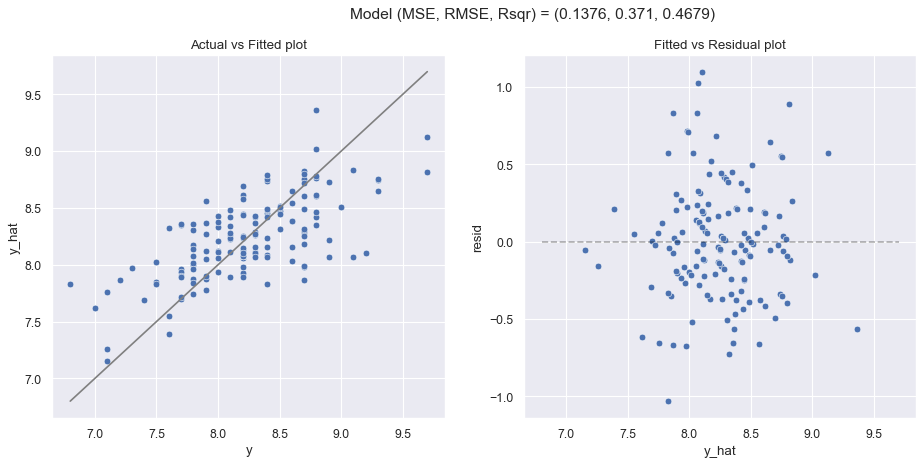

In [21]:
model_fit(test_linear_model, X_train, y_train, plot = True);

Note that the actual vs fitted plot shows that the points are close to the line. This indicates that the assumption of a linear model is justified. The residual plot looks fairly random which is good but there is a some pattern specifically across the y = 0 line. Therefore a linear model is valid and we will continue to investigate linear models in the rest of the report.

## LASSO 🤠

We now perform Lasso with interaction terms. We also scale the features to a standard normal. This makes the correlation coefficients smaller and the variance smaller.

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures

# Create a pipeline that uses LASSO
lasso_model = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False, interaction_only=True), #Interaction terms
    StandardScaler(), # Scale features to normal
    LassoCV(alphas=[0.0001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 100, 1000])
    ).fit(X_train, y_train)

# R squared
print_r2(lasso_model)

coefs = lasso_model['lassocv'].coef_
feature_names = lasso_model[:-1].get_feature_names_out()
importance_ranking = sorted(zip(map(abs, coefs), feature_names, coefs), reverse=True)

for rank, (coef, feature, coef_sign) in enumerate(importance_ranking[:10]):
    print("Rank {}: {} ({})".format(rank+1, feature, coef_sign))


# Most important coefficients
features_lasso = [x for x in feature_names[coefs != 0]]
print("Selected alpha:", lasso_model['lassocv'].alpha_)
print("Selected features:", features_lasso)


Train R^2 0.3072449847968044
Test R^2 0.2630821859053073
Rank 1: Michael (0.12150249144815099)
Rank 2: Andy Phyllis GregDaniels (0.03550184183700628)
Rank 3: n_directions Phyllis GregDaniels (0.02930269118682564)
Rank 4: Andy Angela Kevin (0.024615504265178837)
Rank 5: n_speak_char Jim Stanley (0.014590480830256464)
Rank 6: Creed Jim Kevin (0.014298361773903309)
Rank 7: Darryl Michael Other (0.012146891592694175)
Rank 8: Erin Oscar Other_D (-0.009746063694485704)
Rank 9: OwenEllickson (-0.006778794365269084)
Rank 10: Darryl Stanley OwenEllickson (-0.004653112920086866)
Selected alpha: 0.1
Selected features: ['Michael', 'OwenEllickson', 'n_directions Phyllis GregDaniels', 'n_speak_char Jim Stanley', 'Andy Angela Kevin', 'Andy Phyllis GregDaniels', 'Creed Jim Kevin', 'Darryl Michael Other', 'Darryl Stanley OwenEllickson', 'Erin Oscar Other_D']


Although LASSO gives us a lower R^2 score, the train and test R^2 are much closer which suggests more consistent modelling. We also get a list of important features which gives us insight into features we shall keep.

We see that Michael is the most important factor. This is well documented [3], and was reflected in previous data exploration. We also see the Owen Ellickson has a negative coefficient, meaning that he is a bad writer. The writer Greg Daniels cowrote the Finale episode, which was the highest rated show. He also shows up high on the list with positive coefficients.

## ElasticNet 🥅

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures

# Create a pipeline that uses ElasticNetCV
elastic_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), #Interaction terms
    StandardScaler(), # Scale features to normal
    ElasticNetCV(alphas=[0.0001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 100, 1000],cv=10)
    ).fit(X_train, y_train)

# R squared
print_r2(elastic_model)

coefs = elastic_model['elasticnetcv'].coef_
feature_names = elastic_model[:-1].get_feature_names_out()
importance_ranking = sorted(zip(map(abs, coefs), feature_names, coefs), reverse=True)

for rank, (coef, feature, coef_sign) in enumerate(importance_ranking[:10]):
    print("Rank {}: {} ({})".format(rank+1, feature, coef_sign))


# Most important coefficients
features_elastic = [x for x in feature_names[coefs != 0]]
print("Selected alpha:", elastic_model['elasticnetcv'].alpha_)
print("Selected features:", features_elastic)


Train R^2 0.5077279692190134
Test R^2 0.4707610239283051
Rank 1: Michael (0.11155383032743071)
Rank 2: Phyllis GregDaniels (0.06615639504689592)
Rank 3: Angela BrentForrester (0.038231375660066035)
Rank 4: Erin Other (-0.02573533757447681)
Rank 5: n_speak_char Michael (0.0256094812593567)
Rank 6: RobertPadnick JeffreyBlitz_D (-0.02469763538090061)
Rank 7: Erin TuckerGates_D (0.024183856382070358)
Rank 8: BJNovak TuckerGates_D (0.02411275943069674)
Rank 9: Erin GregDaniels (0.023712238134332937)
Rank 10: Andy OwenEllickson (-0.02317719125929005)
Selected alpha: 0.1
Selected features: ['Michael', 'OwenEllickson', 'n_lines OwenEllickson', 'n_directions Michael', 'n_words Phyllis', 'n_words OwenEllickson', 'n_speak_char Jim', 'n_speak_char Michael', 'Andy Angela', 'Andy Ryan', 'Andy GeneStupnitsky', 'Andy LeeEisenberg', 'Andy OwenEllickson', 'Andy KenKwapis_D', 'Angela Darryl', 'Angela AaronShure', 'Angela BrentForrester', 'Angela DavidRogers_D', 'Angela JeffreyBlitz_D', 'Darryl PaulLieber

ElasticNet is an alternative model that improves on LASSO. There is an obvious improvent in R^2 score. There are also more features that are important.

## Other models

Additionally, we tried other models. Of particular interst are `LassoLars` which yields a negative R^2, and `DecisionTreeRegressor` gives a train R^2 of 1. The other models (such as `KNeighborsRegressor` and `BayesianRidge`) yielded similar, but slight less effective results than `ElasticNetCV`. 

## Final model 🏁

We now run our final model.

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures

# Create a pipeline that uses ElasticNetCV
final_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), #Interaction terms
    StandardScaler(), # Scale features to normal
    ElasticNetCV(alphas=[0.1],cv=10) 
    #LinearRegression()
    ).fit(X_train, y_train)

# R squared
print_r2(final_model)

coefs = final_model[-1].coef_
feature_names = final_model[:-1].get_feature_names_out()
importance_ranking = sorted(zip(coefs, feature_names), reverse=True) # Sort coefficients

Train R^2 0.5077279692190134
Test R^2 0.4707610239283051


This R^2 is still decent like before. We now get a list of all positive and negative coefficients ordered by value.

In [25]:
# Positive correlations
for rank, (coef, feature) in enumerate(importance_ranking):
    if coef>0:
        print("Rank {}: {} ({})".format(rank+1, feature, coef))

Rank 1: Michael (0.11155383032743071)
Rank 2: Phyllis GregDaniels (0.06615639504689592)
Rank 3: Angela BrentForrester (0.038231375660066035)
Rank 4: n_speak_char Michael (0.0256094812593567)
Rank 5: Erin TuckerGates_D (0.024183856382070358)
Rank 6: BJNovak TuckerGates_D (0.02411275943069674)
Rank 7: Erin GregDaniels (0.023712238134332937)
Rank 8: Angela JeffreyBlitz_D (0.023144027062168344)
Rank 9: Other GregDaniels_D (0.02147670694172823)
Rank 10: Kelly Stanley (0.01963533765717639)
Rank 11: Dwight Phyllis (0.01827713548896414)
Rank 12: n_speak_char Jim (0.017765630437207473)
Rank 13: Andy KenKwapis_D (0.017091849841392535)
Rank 14: Andy Angela (0.016151742096465777)
Rank 15: Jim Toby (0.01211967304315399)
Rank 16: n_directions Michael (0.008155531112597923)
Rank 17: Angela Darryl (0.004791747535632599)
Rank 18: Jim GregDaniels_D (0.0037139106057728372)
Rank 19: n_words Phyllis (0.003107540098722392)
Rank 20: LeeEisenberg MichaelSchur (0.002595907434795695)
Rank 21: Dwight Jim (0.0024

In [26]:
# Negative correlations
for rank, (coef, feature) in enumerate(importance_ranking):
    if coef<0:
        print("Rank {}: {} ({})".format(rank+1, feature, coef))

Rank 1525: Other RandallEinhorn_D (-0.00032016818371342567)
Rank 1526: AaronShure Other_D (-0.0014367457659545408)
Rank 1527: Erin AaronShure (-0.001944720741005168)
Rank 1528: n_words OwenEllickson (-0.004508356724436552)
Rank 1529: Darryl PaulLieberstein_D (-0.004985966222964719)
Rank 1530: Kelly RobertPadnick (-0.0077787053501034535)
Rank 1531: Angela AaronShure (-0.009490301422448796)
Rank 1532: n_lines OwenEllickson (-0.012004002397138279)
Rank 1533: Erin Other_D (-0.01223127276524276)
Rank 1534: Andy Ryan (-0.014802346272132028)
Rank 1535: OwenEllickson (-0.015184326282416123)
Rank 1536: Oscar CharlieGrandy (-0.015692469018867495)
Rank 1537: Meredith RandallEinhorn_D (-0.016365193962114236)
Rank 1538: Andy OwenEllickson (-0.02317719125929005)
Rank 1539: RobertPadnick JeffreyBlitz_D (-0.02469763538090061)
Rank 1540: Erin Other (-0.02573533757447681)


The degree 1 nonzero coefficients are Michael (positive) and writer OwenEllickson (negative). This means that for a high IMDB rating, Michael needs to be on the show with a high number of lines, and OwenEllickson cannot be a writer.

All other coefficients are for the degree 2 terms. The highest ranked writers are GregDaniels, BrentForrester and MichaelSchur. The highest ranked directors are TuckerGates and JeffreyBlitz. None of these people are in the negative correlations list. Thus we shall make these people writers and directors by setting their One Hot feature to be 1, and every other person to be 0.

We now refine our ranking to discard any coefficients that involve any writer or director that was not chosen.

In [27]:
writers_directors = ['GregDaniels','BrentForrester','MichaelSchur','TuckerGates_D','JeffreyBlitz_D'] # directors and writers we keep
all_writers_directors = writers.join(direc.add_suffix('_D')).keys() # get list of all directors and writers
discard_writers_directors = set(all_writers_directors) - set(writers_directors) # people to discard

print("POSITIVE COEFFICIENTS") # Get positive coef
for rank, (coef, feature) in enumerate(importance_ranking): 
    features = feature.split(' ') # Split features label
    if coef>0 and not(any(item in discard_writers_directors for item in features)): # Check if positive and no discards
        print("Rank {}: {} ({})".format(rank+1, feature, coef))
        
    
print("\nNEGATIVE COEFFICIENTS") # Get positive coef
for rank, (coef, feature) in enumerate(importance_ranking): 
    features = feature.split(' ') # Split features label
    if coef<0 and not(any(item in discard_writers_directors for item in features)): # Check if positive and no discards
        print("Rank {}: {} ({})".format(rank+1, feature, coef))    

POSITIVE COEFFICIENTS
Rank 1: Michael (0.11155383032743071)
Rank 2: Phyllis GregDaniels (0.06615639504689592)
Rank 3: Angela BrentForrester (0.038231375660066035)
Rank 4: n_speak_char Michael (0.0256094812593567)
Rank 5: Erin TuckerGates_D (0.024183856382070358)
Rank 7: Erin GregDaniels (0.023712238134332937)
Rank 8: Angela JeffreyBlitz_D (0.023144027062168344)
Rank 10: Kelly Stanley (0.01963533765717639)
Rank 11: Dwight Phyllis (0.01827713548896414)
Rank 12: n_speak_char Jim (0.017765630437207473)
Rank 14: Andy Angela (0.016151742096465777)
Rank 15: Jim Toby (0.01211967304315399)
Rank 16: n_directions Michael (0.008155531112597923)
Rank 17: Angela Darryl (0.004791747535632599)
Rank 19: n_words Phyllis (0.003107540098722392)
Rank 21: Dwight Jim (0.0024344352075955167)
Rank 26: Meredith Ryan (0.0011995093039640756)

NEGATIVE COEFFICIENTS
Rank 1534: Andy Ryan (-0.014802346272132028)


The only non-writer/director negative coefficient is Andy-Ryan. We wish to minimise the appearence of one of these characters. Since Andy is higher on the positive list, we shall make Ryan 0. All 16 other characters will speak.

Out of the general information features, `n_lines` does not affect the model. We shall choose this to be the sum of all lines said by the named characters plus a random number. Also, `n_speak_char` will be chosen as the number of speaking characters (16) plus a random number. We shall choose an number for `n_directions` plus a random number. Finally, `n_words` will be chosen such that the ratio between the number of spoken lines and number of spoken words is around 11.


Finally, we choose the number of lines spoken by each character. We shall choose reasonable numbers from the distribution of our data. We order the number of lines each character gets by the importance ranking, i.e. Michael, Phyllis, Angela, Erin, Kelly, Stanley, Dwight, Andy, Jim, Toby, Darryl, Meredith. These characters will get a high number of lines based on the distribution of our data. Characters not listed as important will get a low number of lines.

We implement all these choices below.

In [28]:
# Define ideal episode
People = {# Writers and directors
    'GregDaniels':1, 
    'BrentForrester':1,
    'MichaelSchur':1,
    'TuckerGates_D':1,
    'JeffreyBlitz_D':1,
}

Characters = {
    # Michael
    'Michael':180, 
    # Important characters
    'Phyllis':50,
    'Angela':40,
    'Erin':25,
    'Kelly':20,
    'Stanley':20,
    'Dwight':40,
    'Andy':20,
    'Jim':40,
    'Toby':10,
    'Darryl':10,
    'Meredith':5,
    # Other characters
    'Creed':5,
    'Kevin':5,
    'Oscar':5,
    'Pam':20,
    'Ryan':0, # Must be 0
}
n_lines = sum(Characters.values()) + np.random.randint(30) # number of lines
General = {
    # General info
    'n_directions': 55 + np.random.randint(30), # Ensure reasonable directions count
    'n_speak_char':16 + np.random.randint(10), # Ensure > sum of all characters
    'n_lines': n_lines, # Ensure sums > sum of all character lines. Ensure reasonable total
    'n_words':n_lines*11 + np.random.randint(400), # Ensure reasonable word/line ratio
}
ideal_episode = People | Characters | General # Ideal episode

ideal_episode.update({key: (ideal_episode[key] if key in ideal_episode.keys() else 0)for key in head}) # Pad ungiven values with 0
ideal_episode.update({key: [value] for key, value in ideal_episode.items()}) # Put all elements in a list
ideal_episode = pd.DataFrame.from_dict(ideal_episode) # Convert to pd dataframe
ideal_episode = ideal_episode[head] # Rearange columns


final_prediction = final_model.predict(ideal_episode)[0]

In [29]:
print('Preicted IMDB rating of sepecial show: ', final_prediction)

Preicted IMDB rating of sepecial show:  19.59547194336719


As linear models are unbounded, there is nothing enforcing the maximum IMDb rating of 10. For example, if Michael has an unreasonablly large number of lines, the IMDb rating will be very large.

The Office is a common dataset in literature. In [2], they used a variety of different models, including Stochastic Gradient Descent and K Neigbours and got an R^2 of around 0.4.

Modelling real world social data is generally hard [4], especially when the data is subjective.

## 4. Discussion and Conclusions


Our final model is ElasticNetCV, a cross validated linear model incorporating ridge and LASSO regression with interaction terms. It looks at the characters, writers, directors, and number of lines and determines which combinations of them have significant predictive power for IMDb rating. If a factor is not useful, it is removed from the model. The result is a list of coefficients: positive values indicate that that combination of features increases IMDb rating on average, while negative coefficients decrease it.

Our model has a test R^2 value near 0.5. This means that roughly 50% of the variation in IMDb rating can be explained by variation in the features chosen by the model. This is a relatively high score compared to other models in the literature, and indicates reasonably strong predictive strength. 

The model chooses features in line from what we would expect given our preliminary data analysis. The largest takeaway from that was the dominant popularity of Michael’s character, as well as the highest performing writers and directors. Indeed, the single most impactful feature in the model by far is the inclusion of Michael with a high number of lines.

Our recommendation for NBC universal is to make an episode written by a collaboration between Greg Daniels, Brent Forrester, and Michael Schur. All characters should be included except Erin and Ryan, with Michael given a large number of lines. Tucker Gates and Jeffrey Blitz should direct the episode.



## 5. References

[1] Ralhan, A. (2018, May) *The Office lines*. https://data.world/abhinavr8/the-office-scripts-dataset. Accessed 28/02/2023.

[2] Akula, R., Wieselthier, Z., Martin, L., & Garibay, I. (2019, April). *Forecasting the Success of Television Series using Machine Learning*. In 2019 SoutheastCon (pp. 1-8). IEEE.

[3] IMDb. *The Best 50 TV Characters Ever*. https://www.imdb.com/list/ls008918531/mediaviewer/rm3447556352/. Accessed 10/03/2023.

[4] MathsCareers. (2021, September). *Real World Examples of Mathematical Modelling*. https://www.mathscareers.org.uk/real-world-examples-of-mathematical-modelling/. Accessed 10/03/2023.